## STEP 4 - Interest Rate prediction

The fourth part of the project aims to automate LendingClub's lending decisions fully by creating a prediction model that predict loan interest rate This model will utilize data from LendingClub to make predictions loan interest rate prediction. Why this model will be useful for Lending Club?:
 
* **Improved risk assessment**: By using a predictive model to determine interest rates, Lending Club can better assess the risk of each loan applicant. This can lead to more accurate pricing of loans, which can reduce default rates and improve profitability.

* **Increased efficiency**: By automating the interest rate determination process, Lending Club can reduce the time and resources needed to manually assess loan applications. This can increase efficiency and reduce costs.

* **Enhanced customer experience**: With a more accurate and automated interest rate determination process, Lending Club can provide a better customer experience by quickly and accurately providing loan offers to applicants.

* **Competitive advantage**: By using predictive modeling to determine interest rates, Lending Club can gain a competitive advantage in the marketplace. This can help attract new customers and increase market share.

Overall, a predictive model for interest rate determination can be a powerful tool for Lending Club. It can help the company make more informed decisions about loan pricing and risk assessment, which can lead to increased profitability and customer satisfaction.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import helpers
import warnings 
 
from joblib import dump
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
warnings.filterwarnings('ignore')

In [3]:
''' Reading accepted dataset '''
df_accepted = pd.read_csv("lending-club/accepted.csv")
df_accepted = df_accepted.drop_duplicates()

In [4]:
''' Removing rows with missing grade '''
df_accepted = df_accepted[df_accepted.grade.isnull() == False]

In [5]:
''' Dropping columns that have too much missing values '''
cols_to_remove = helpers.get_cols_with_large_missing_vals(df_accepted)

In [6]:
''' Appending columns to remove with id column '''
cols_to_remove = list(cols_to_remove.keys())
cols_to_remove.append("id")

In [7]:
''' Dropping columns that have too many missing values'''
df_accepted = df_accepted.drop(cols_to_remove, axis=1)

We can see that there are more columns that seem not to have very informative meaning. For instance, url or zip_code. Some date columns are also not meaningful.

In [8]:
''' Creating list with more missing values'''
more_useless_cols = ['url', 'pymnt_plan', 'title', 'zip_code',
                     'last_pymnt_d', 'debt_settlement_flag',
                     'issue_d', 'last_credit_pull_d', 'earliest_cr_line',
                     'sec_app_earliest_cr_line', 'next_pymnt_d']

In [9]:
''' Dropping useless columns '''
df_accepted = df_accepted.drop(more_useless_cols, axis=1)

## Interest Rate EDA

### What is interest rate?
The interest rates for loans on LendingClub vary depending on several factors, including the borrower's creditworthiness, the amount of the loan, and the length of the loan term.

In [10]:
''' Creating list with columns to drop '''
drop_cols = ['desc', 'issue_d', 'revol_util',  'sec_app_revol_util', 'initial_list_status', 'installment', 'chargeoff_within_12_mths', 'sec_app_chargeoff_within_12_mths', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'pub_rec_bankruptcies', 'collections_12_mths_ex_med', 'sec_app_collections_12_mths_ex_med', 'mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog', 'acc_now_delinq', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'sec_app_inq_last_6mths', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'addr_state', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'disbursement_method', 'loan_status', 'out_prncp', 'out_prncp_inv', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'open_acc_6m', 'open_act_il', 'sec_app_open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'il_util', 'policy_code']

In [11]:
''' Dropping rows of columns that have less or equal 200 missing values'''
results = df_accepted.isnull().sum() 
for i in range(0, len(results)): 
    if results[i] <= 200:
        col = results.index[i]
        df_accepted = df_accepted.dropna(subset=col) 

In [12]:
''' Creating list of targets '''
targets = ['grade', 'sub_grade', 'int_rate']

In [13]:
''' Dropping columns that will not be useful for prediction'''
df_accepted = df_accepted.drop(columns=drop_cols, errors='ignore')

Since there is in the dataset both individual and joint applications. I'll only consider individual rows that do not have a single feature in "joint" cols. And joint applications that do not have missing values in "joint" columns

In [14]:
''' Taking individual loans without joint values '''
df_individual = df_accepted[df_accepted[['verification_status_joint', 'dti_joint', 'sec_app_open_acc',
                                         'sec_app_fico_range_low', 'sec_app_fico_range_high',
                                         'annual_inc_joint']].isnull().all(axis=1)]

In [15]:
''' Taking joint loans without missing joint values '''
df_joint = df_accepted[df_accepted[['verification_status_joint', 'dti_joint', 'sec_app_open_acc', 'sec_app_fico_range_low',
                                    'sec_app_fico_range_high', 'annual_inc_joint']].notnull().all(axis=1)]

In [85]:
''' Combining final dataset with joint and individual loans '''
df_accepted = pd.concat([df_joint, df_individual], ignore_index=True)

In [86]:
''' Removing outliers '''
df_accepted = helpers.remove_num_outliers(df_accepted, nunique=100000, thres=0.99)

In [87]:
''' Removing outliers '''
df = df_accepted.copy()
df = helpers.remove_outliers_col(df, "loan_amnt", 0.95)
df = helpers.remove_outliers_col(df, "annual_inc", 0.95)
df = helpers.remove_outliers_col(df, "dti", 0.95)
df = helpers.remove_outliers_col(df, "fico_range_low", 0.95)
len(df), len(df_accepted)

(1100764, 1784510)

In [88]:
''' Updating df_accepted dataframe '''
df_accepted = df.copy()

Since the goal of step 4 is to predict loan interest rates, I wanted to have a sample that have equal sizes of each sub grade in order to create a model that can predict interest rates of all subgrades.

In [94]:
''' Taking stratified sample by sub grade '''
df_accepted_step4 = helpers.stratified_sample(df_accepted, 'sub_grade')

In [96]:
''' Separating target value from the whole dataset '''
df_step4_targets = df_accepted_step4[["int_rate"]]

### Exploratory Data Analysis

Now I will analyse different numerical values based on different interest rates.

#### Loan Amount vs interest rate

I wanted to see the distribution between loans that have higher than median loan amount and their difference in interest rate.

We can see that in general loans with higher loan amount also had higher interest rate.

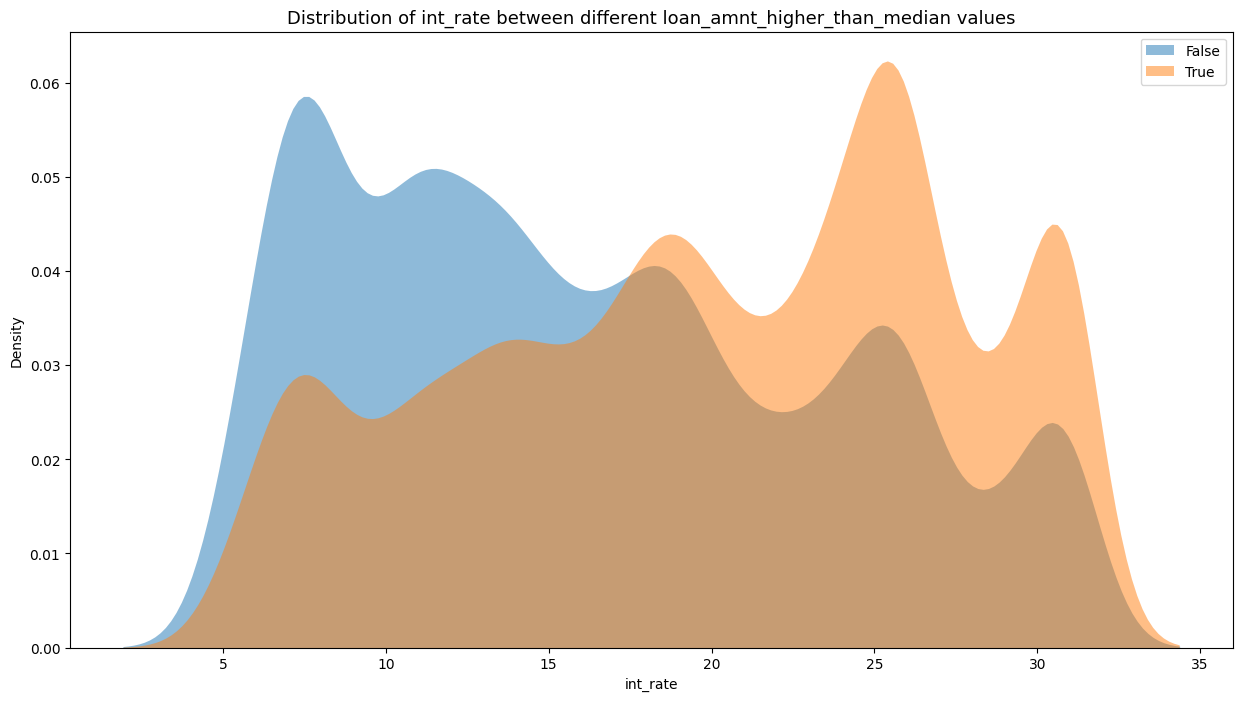

In [97]:
''' Plotting loans with higher and lower than median loan_amnt '''
df = df_accepted_step4.copy()
loan_amnt_median = df_accepted_step4.loan_amnt.median()
df['loan_amnt_higher_than_median'] = df_accepted_step4.loan_amnt >= loan_amnt_median
helpers.plot_kde_plot(df, 'int_rate', 'loan_amnt_higher_than_median')

#### Annual Income vs interest rate

I also wanted to see the same for annual income. Here the difference is not as remarkable and we cannot state that loans with higher annual income have higher or lower interest rate.

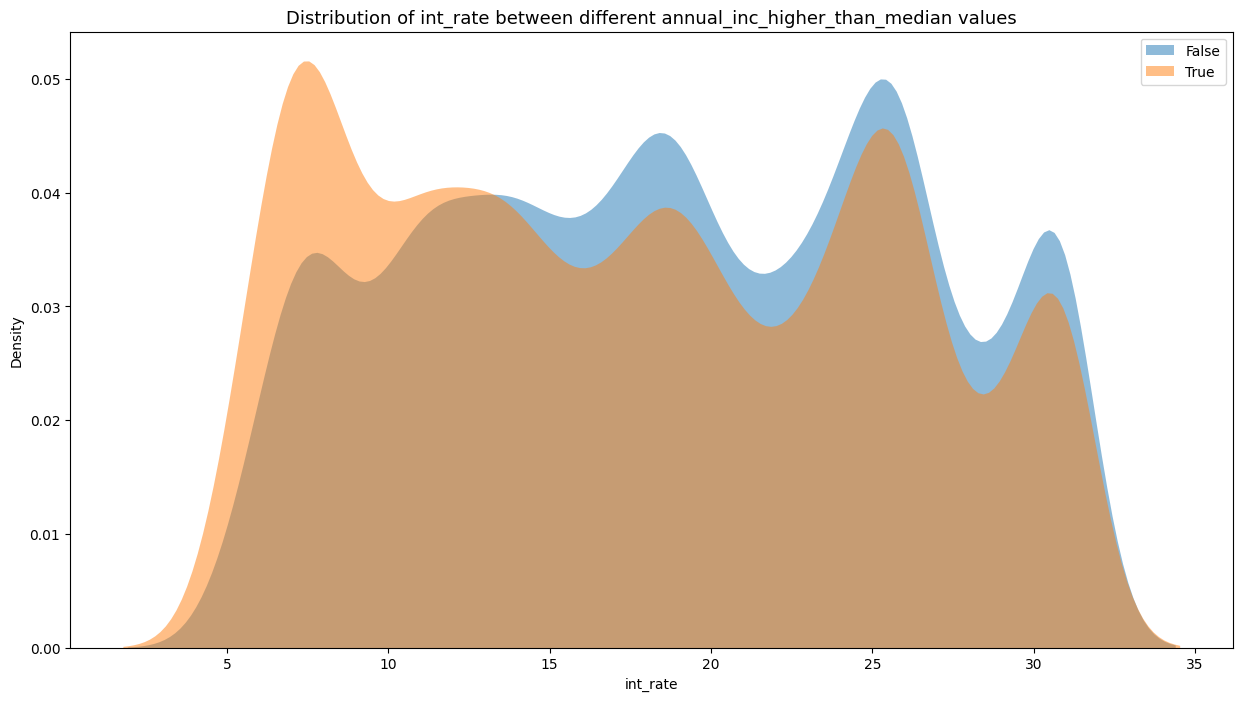

In [98]:
''' Plotting loans with higher and lower than median annual_inc '''
df = df_accepted_step4.copy()
annual_inc_median = df_accepted_step4.annual_inc.median()
df['annual_inc_higher_than_median'] = df_accepted_step4.annual_inc >= annual_inc_median
helpers.plot_kde_plot(df, 'int_rate', 'annual_inc_higher_than_median')

#### Term vs interest rate

Here once again, we can see that loans with term 60 months had higher interest rate and loans with 36 months - lower. This can be because longer-term loans carry a higher risk of default, and investors require higher returns to compensate for this risk.

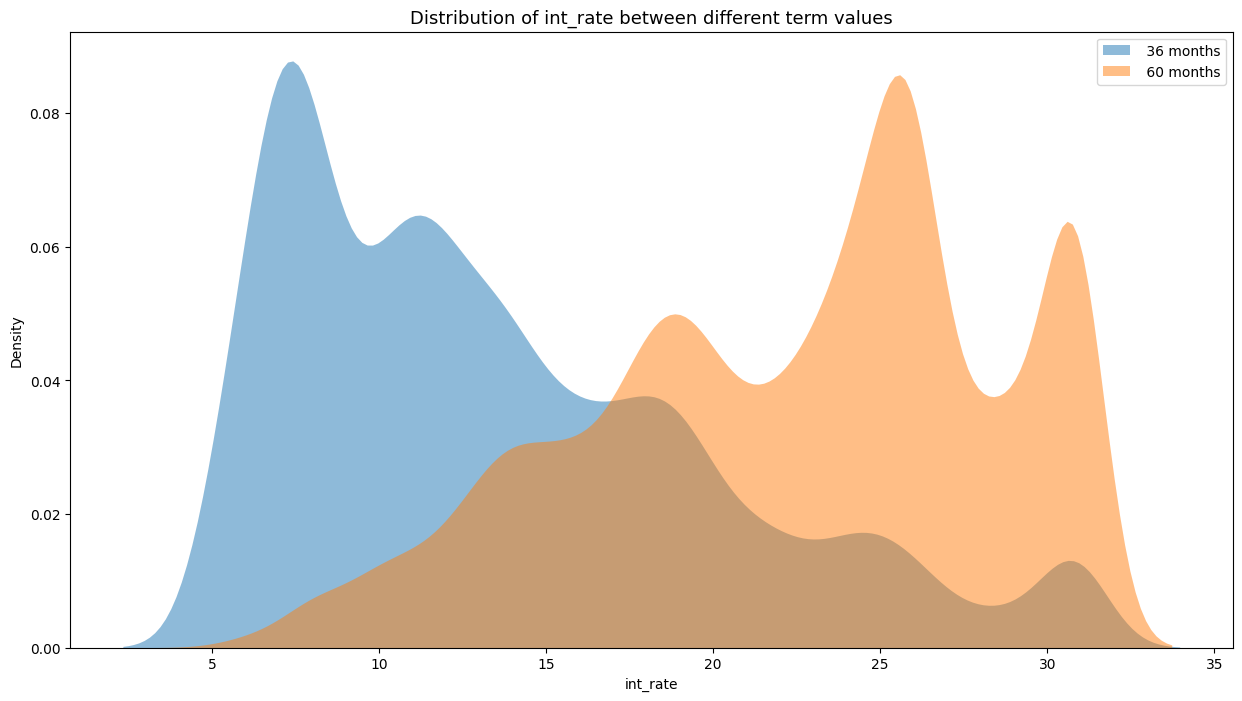

In [99]:
''' Plotting loans with different terms '''
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'term')

#### DTI vs interest rate

Here we can see also a slight difference for loans where applicant had dti higher than median. Those clients also received higher interest rate for their loans.

Borrowers with a high DTI ratio are considered to be a higher risk because they have a larger amount of debt in comparison to their income, which could make it more difficult for them to repay the loan. As a result, these borrowers may be offered higher interest rates to compensate for the higher risk.

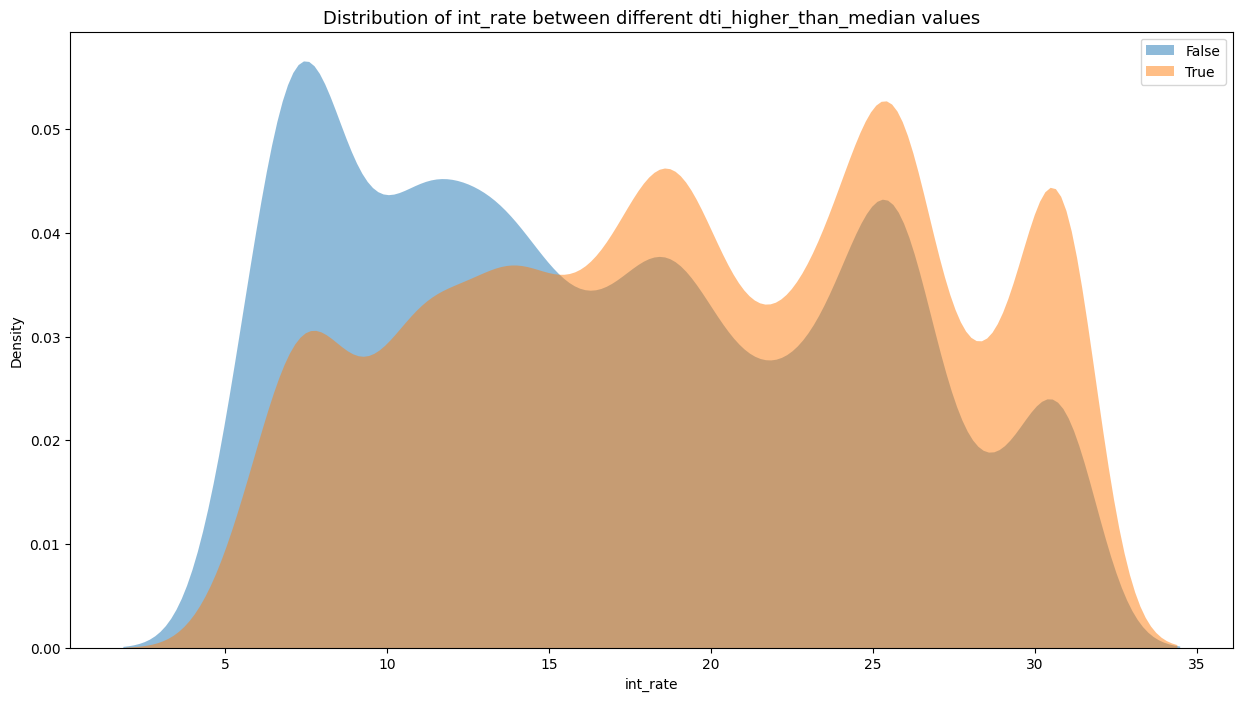

In [100]:
''' Plotting loans with higher and lower than median dti '''
df = df_accepted_step4.copy()
dti_median = df_accepted_step4.dti.median()
df['dti_higher_than_median'] = df_accepted_step4.dti >= dti_median
helpers.plot_kde_plot(df, 'int_rate', 'dti_higher_than_median')

#### Grade vs interest rate

Here we can see a clearly pattern. Grade seems to really play important role in interest rate. The higher the grade, the lower interest rate is. We can see that A has the lowest interest rate where G has the highest. 

Loans with higher grades are considered to be lower risk, and they are generally associated with lower interest rates. For example, an A-grade loan may have an interest rate of 7%, while a G-grade loan may have an interest rate of 25% or higher.

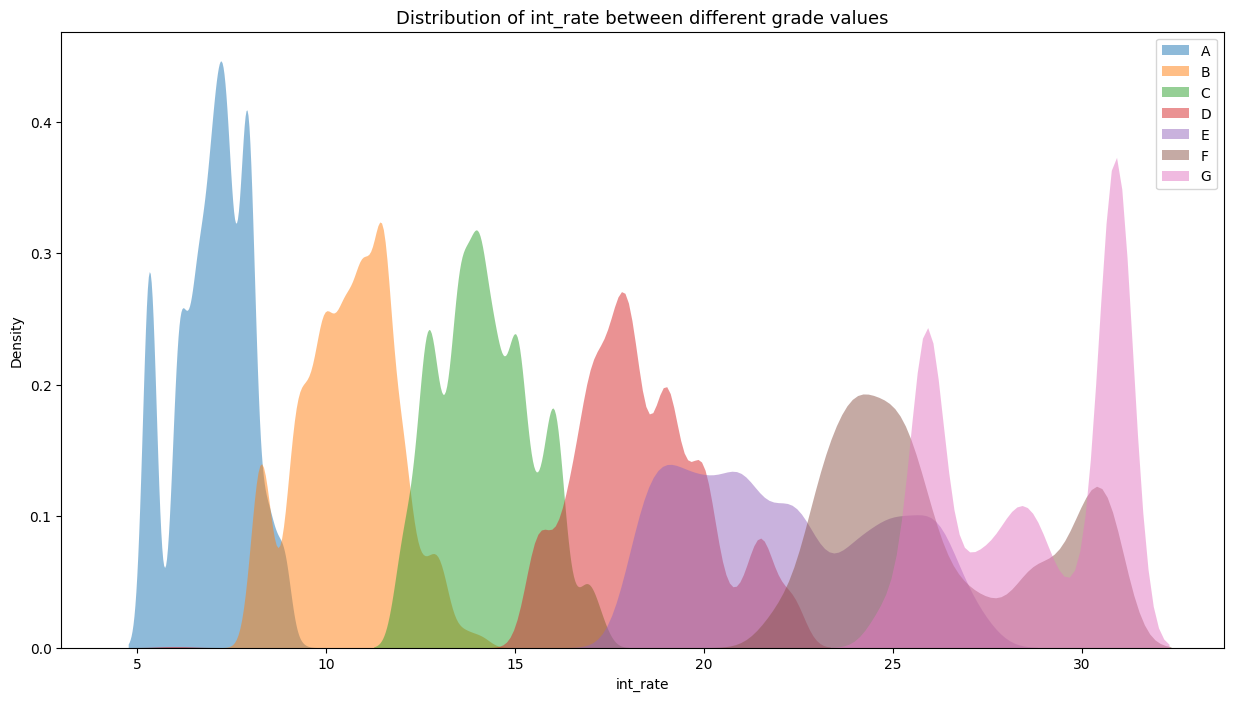

In [101]:
''' Plotting kde for grades and interest rate '''
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'grade')

#### Sub Grade vs interest rate

The similar thing we can see for subgrades as well. The subgrade can have an impact on the interest rate offered to the borrower. Generally, loans with lower subgrades (e.g., A5, B5, C5) are considered to be higher risk and may be associated with higher interest rates compared to loans with higher subgrades (e.g., A1, B1, C1).

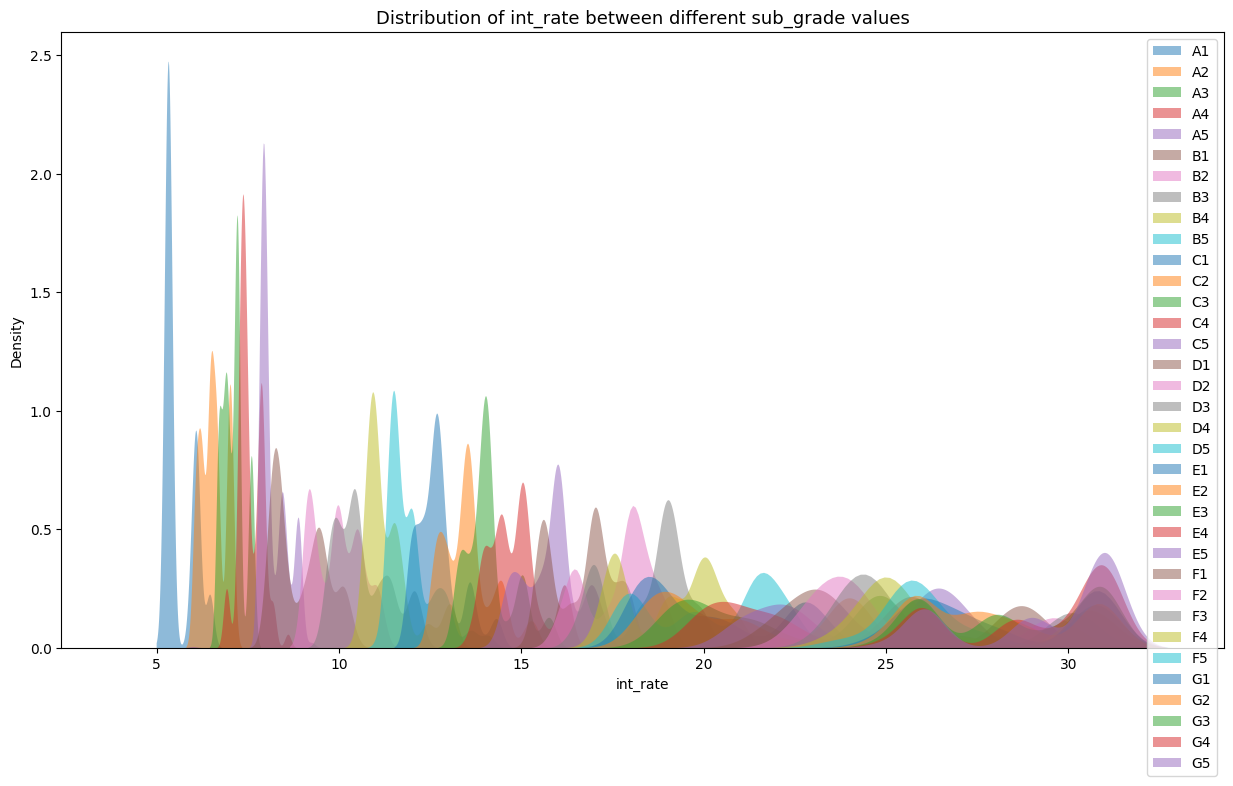

In [102]:
''' Plotting kde for sub_grade and interest rate '''
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'sub_grade')

#### Home Ownership vs interest rate

In this particular KDE plot we cannot see a clear pattern whether home ownership influences higher or lower interest rate, but in general home ownership can be an important information about borrowers creditworthiness.

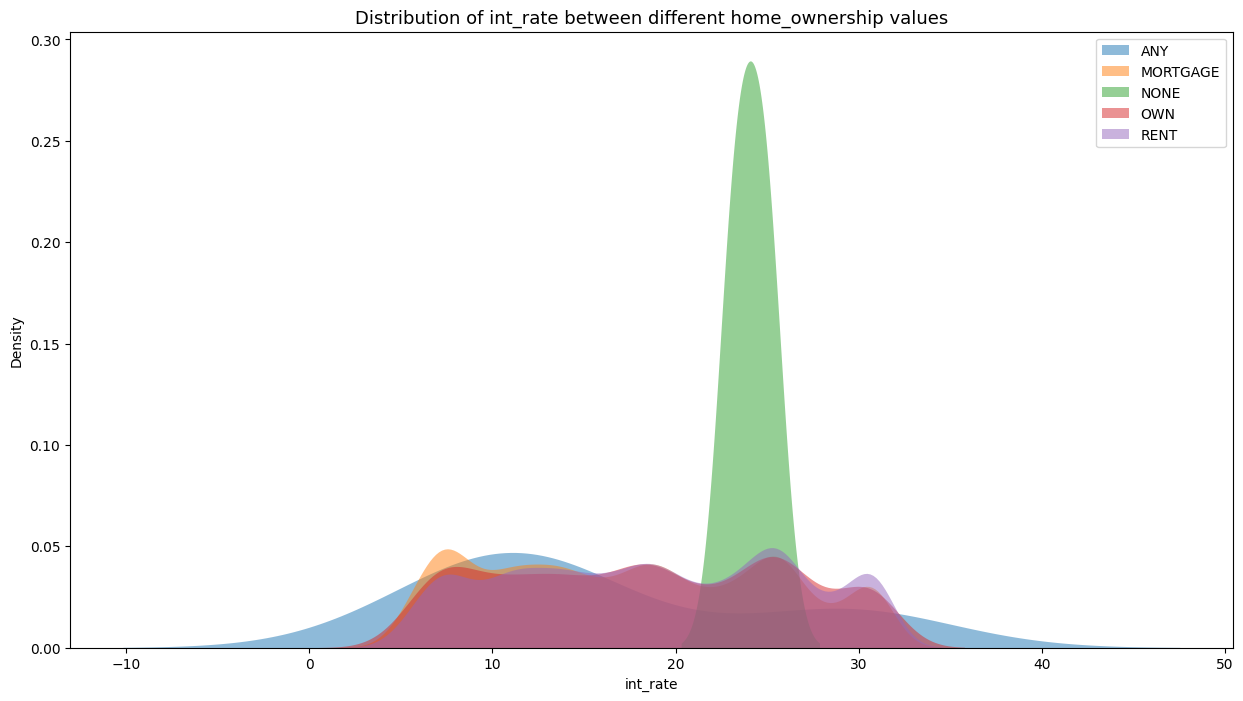

In [103]:
''' Plotting kde for home_ownership and interest rate '''
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'home_ownership')

#### Numerical features scatter plots

A scatter plot can show us the correlation between two numerical features. If the points on the scatter plot form a clear pattern or trend line, then the two features are likely to be correlated. Positive correlation indicates that the two features increase or decrease together, while negative correlation indicates that they move in opposite directions. 

However, in this particular example we cannot see a clean relationship patterns between numerical values

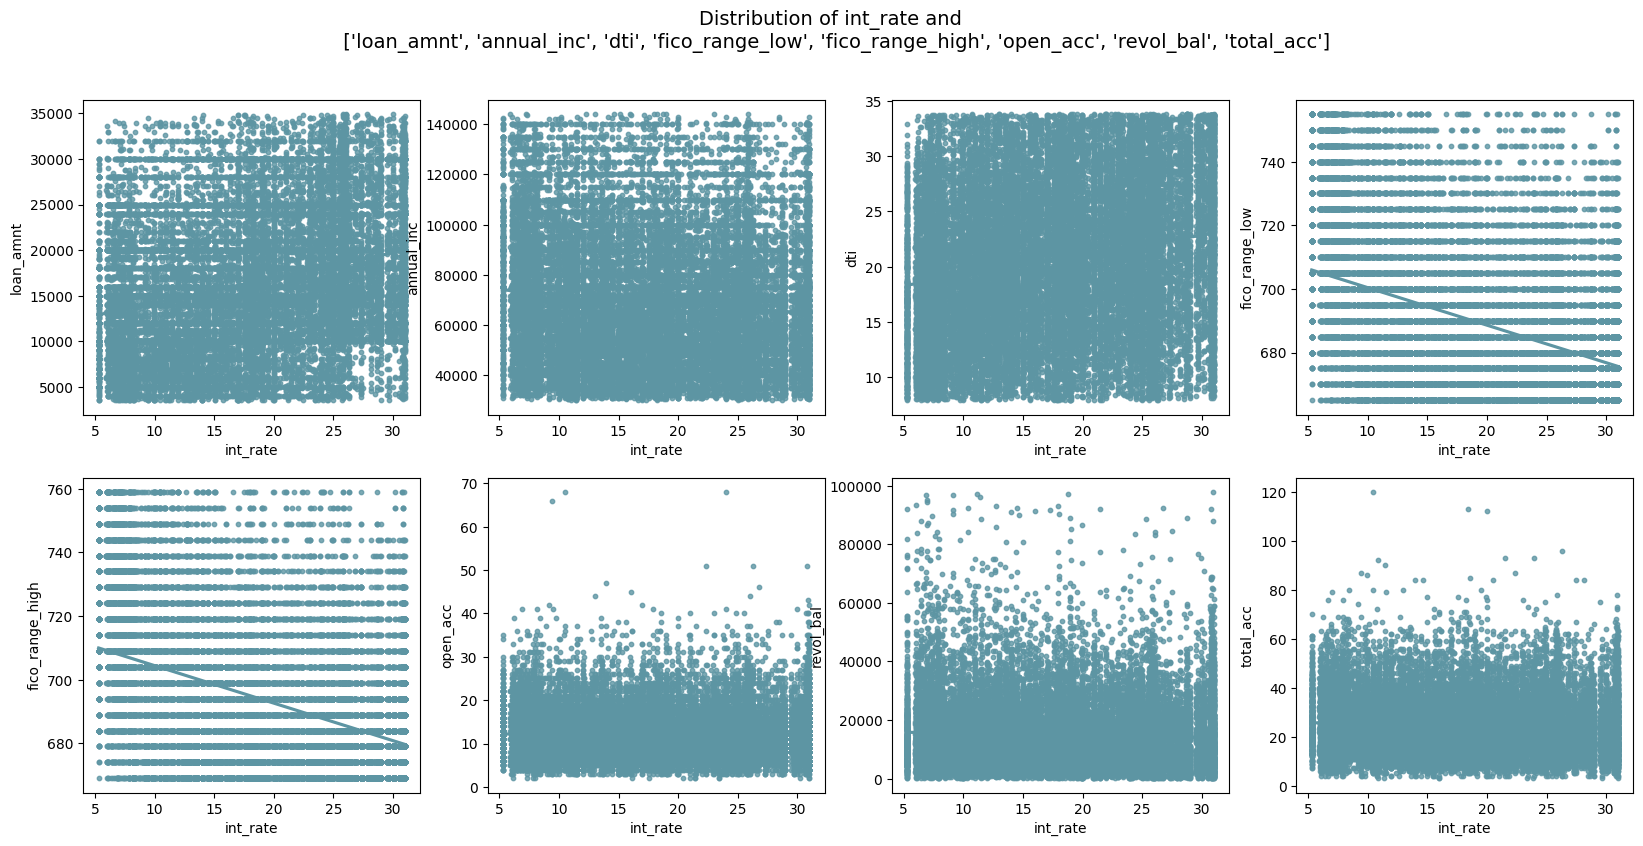

In [104]:
''' Plotting numerical features scatterplot '''
helpers.plot_scatter_plots_with_target(df_accepted_step4, 'int_rate',
                               ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low',
                                'fico_range_high', 'open_acc', 'revol_bal', 'total_acc'])

### Feature Engineer and Correlation exploration

#### Feature Correlation

In [105]:
''' Taking joint and common joint cols in a list ''' 
joint_cols = list( set([col for col in df_accepted_step4.columns if "sec" in col or "joint" in col]))
common_not_joint_cols = [col for col in df_accepted_step4.columns if not ("sec" in col or "joint" in col) and any(col in joint_col for joint_col in joint_cols)]
all_common_cols = joint_cols + common_not_joint_cols

As seen in KDE before, we can clearly see a pattern between grade and interest rate. The higher (G) the grade the higher the interest rate. And letters such A, B and C have negative correlation with interest rate.

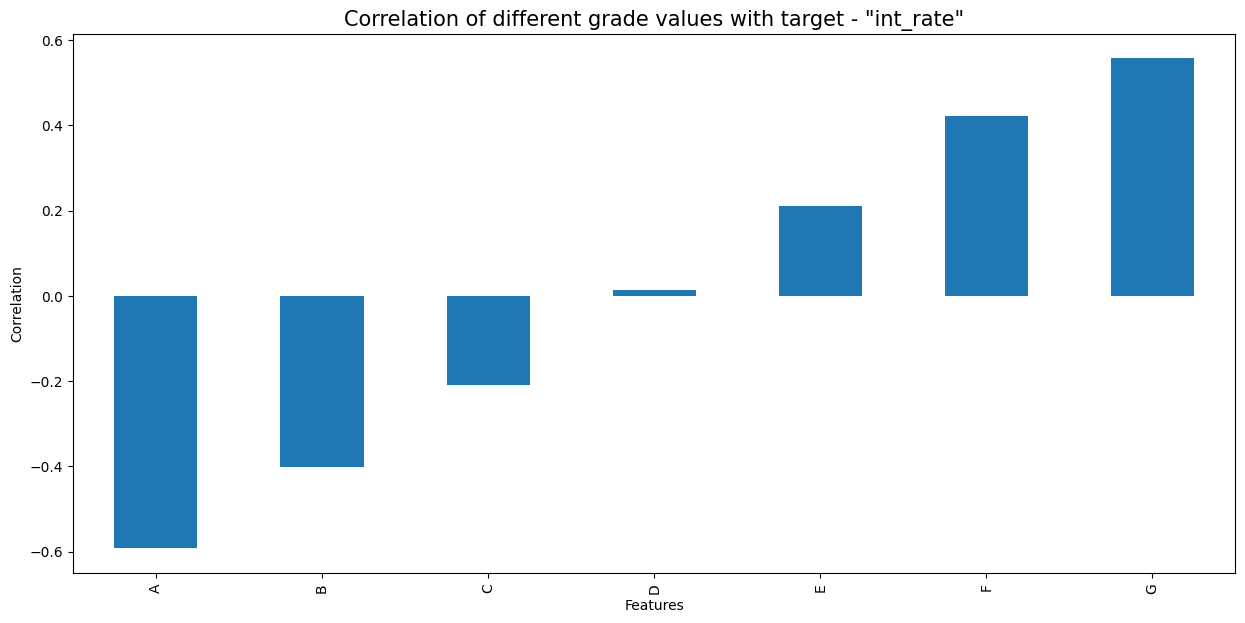

In [106]:
''' Plotting interest rate and grade correlation '''
corr_matrix = pd.get_dummies(df_accepted_step4['grade']).corrwith(df_accepted_step4['int_rate']) 
helpers.plot_cat_col_target_corr(corr_matrix, 'grade', 'int_rate')

We can see the same for the subgrade as well

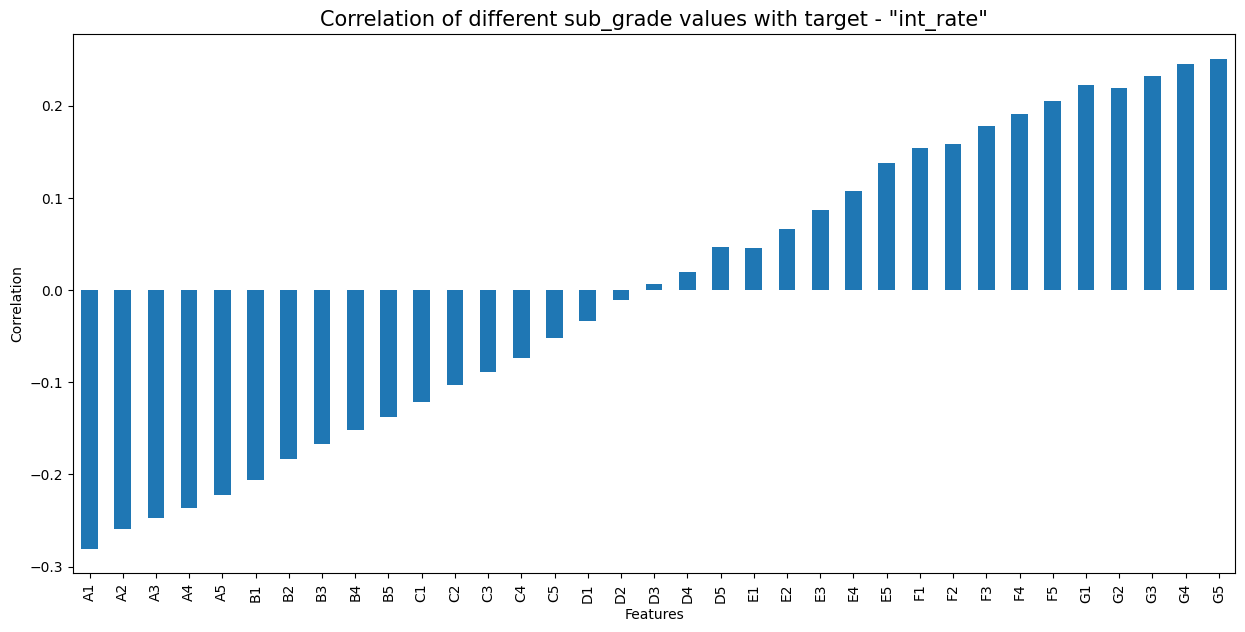

In [107]:
''' Plotting interest rate and subgrade correlation '''
corr_matrix = pd.get_dummies(df_accepted_step4['sub_grade']).corrwith(df_accepted_step4['int_rate']) 
helpers.plot_cat_col_target_corr(corr_matrix, 'sub_grade', 'int_rate')

In pearson correlation map we can also check for the correlations. I will drop features that are not highly correlated with the target variable interest rate and will also remove those that are too strongly correlated with one another. 

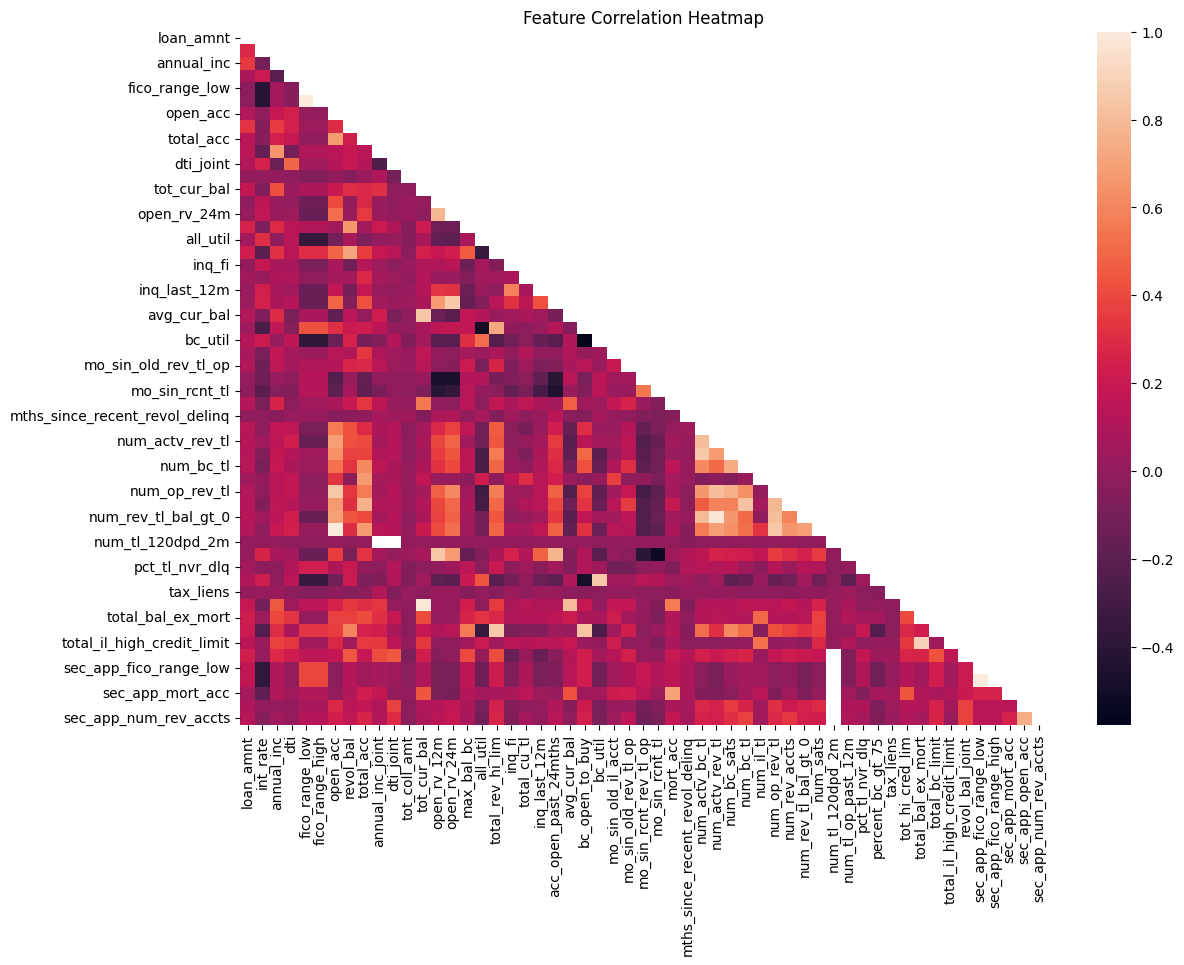

In [108]:
''' Plotting correlation map '''
helpers.plot_pearson_corr_map(df_accepted_step4)

We can see that there were some features that are too correlated with each other, therefore I will leave only one of that pair which is stronger correlated with the target variable int_rate.

In [109]:
''' Taking too correlated features '''
to_drop = helpers.get_too_correlated_cols_and_print_pairs(df_accepted_step4, all_common_cols, df_accepted_step4.corrwith(df_accepted_step4["int_rate"]))

num_rev_tl_bal_gt_0 and num_actv_rev_tl are highly correlated: 0.981. The column dropped will be num_actv_rev_tl.
tot_hi_cred_lim and tot_cur_bal are highly correlated: 0.982. The column dropped will be tot_hi_cred_lim.


In [110]:
''' Dropping too correlated features '''
df_accepted_step4 = df_accepted_step4.drop(to_drop, axis=1)

There are still features in the dataset that are not so correlated with interest rate (the ones that have lower correlation score). I will drop those features that have correlation between -0.1 and 0.1

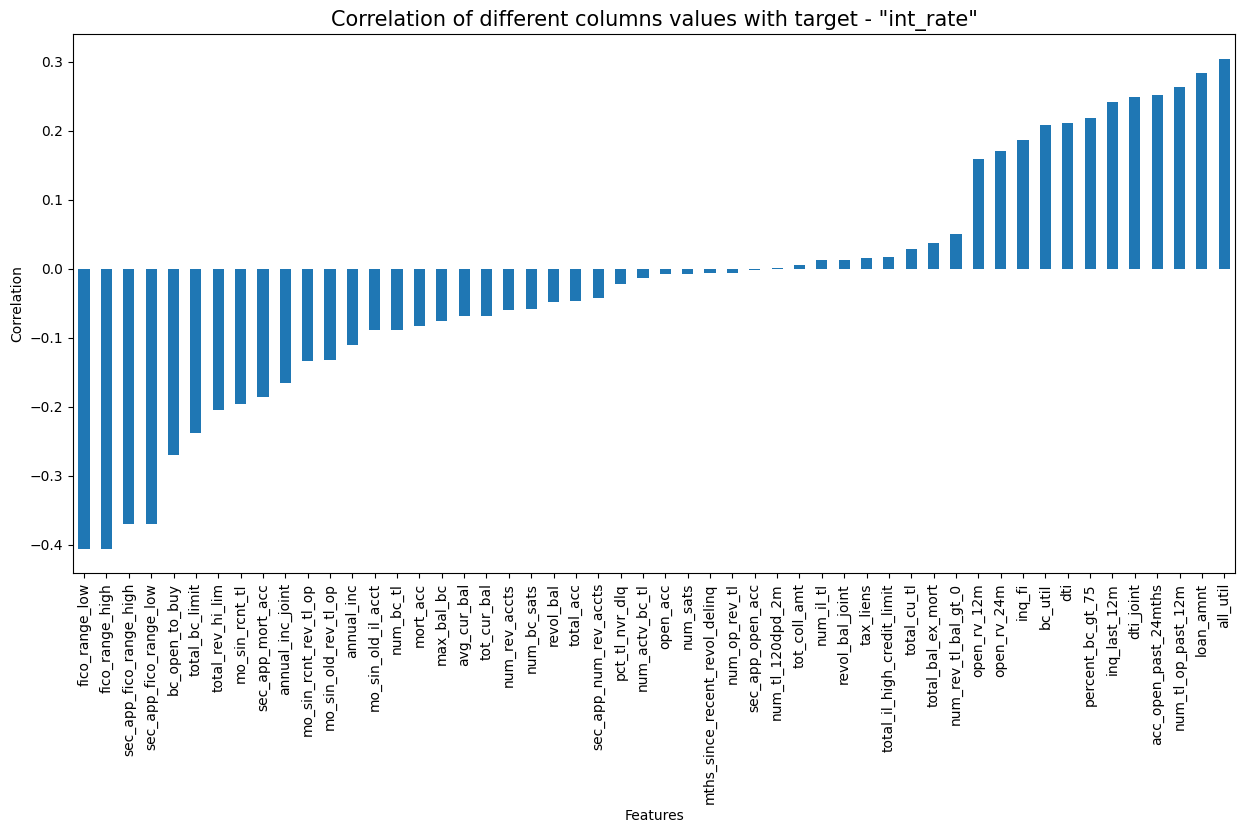

In [111]:
''' Plotting numerical values correlations '''
num_cols = df_accepted_step4.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = df_accepted_step4[[col for col in num_cols if col != "int_rate"]].corrwith(df_accepted_step4["int_rate"]).sort_values()
helpers.plot_cat_col_target_corr(corr_matrix, 'columns', 'int_rate')

In [112]:
''' Taking useless columns in a list '''
corr_df = pd.DataFrame({"variable": corr_matrix.index, "corr_with_int_rate": corr_matrix.values})
corr_df = corr_df.sort_values("corr_with_int_rate", ascending=False)
df_av_cols = corr_df[(corr_df.variable.isin(all_common_cols) == False) & (corr_df.variable != 'int_rate')]
useless_cols = list(df_av_cols[(df_av_cols.corr_with_int_rate <= 0.1) & (df_av_cols.corr_with_int_rate >= -0.1)].variable)

In [113]:
''' Dropping not correlated values '''
df_accepted_step4 = df_accepted_step4.drop(useless_cols, axis=1) 

Now I wanted to perform an **ANOVA** test for other type of values.

The function perform_ANOVA_test performs an ANOVA test on categorical columns in a pandas DataFrame against the "int_rate" column.
    It returns two dictionaries:
    - rejected_cols: containing the columns whose null hypothesis is rejected with a p-value less than 0.05
    - not_rejected_cols: containing the columns whose null hypothesis is not rejected with a p-value greater than or equal to 0.05

In [114]:
''' Performing ANOVA test '''
rejected_cols, not_rejected_cols = helpers.perform_ANOVA_test(df_accepted_step4, all_common_cols)

We can see below the features that rejected the null hypothesis, meaning they are meaningful columns. And the columns in not_rejected_cols will be dropped.

In [115]:
''' Printing out important features '''
print("Categorical columns that seem to have a significant difference in means between continuous numerical target.")
rejected_cols

Categorical columns that seem to have a significant difference in means between continuous numerical target.


{'term': 0.0,
 'grade': 0.0,
 'sub_grade': 0.0,
 'home_ownership': 6.212982477992821e-22,
 'purpose': 0.0,
 'application_type': 3.8857193284452244e-13}

In [116]:
''' Dropping useless features '''
df_accepted_step4 = df_accepted_step4.drop(not_rejected_cols, axis=1) 

In [117]:
''' If term is not dropped, convert it to numerical value '''
if "term" in df_accepted_step4.columns:
    df_accepted_step4['term'] = df_accepted_step4['term'].map({" 36 months": 36, " 60 months": 60})

In [118]:
''' If emp_length is not dropped, convert it to numerical value '''
if "emp_length" in df_accepted_step4.columns:
    df_accepted_step4['emp_length'] = df_accepted_step4['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                            "2 years": 2, "3 years": 3,
                                                                            "4 years": 4, "5 years": 5,
                                                                            "6 years": 6, "7 years": 7,
                                                                            "8 years": 8, "9 years": 9, "10+ years":10})

#### Feature Engineering

The code creates several new columns in the dataframe df_accepted_step4 with different purposes:

* **DTI_Category**: This column categorizes each loan application based on the Debt-to-Income (DTI) ratio into three categories: DTI < 15%, 15% <= DTI <= 25%, and DTI > 25%.

* **fico_avg**: This column calculates the average FICO score range for each loan application based on the high and low FICO score ranges provided in the dataset.

* **sec_app_fico_avg**: This column calculates the average FICO score range for joint loan applications where a second applicant's FICO score is available.

* **LTI**: This column calculates the Loan-to-Income (LTI) ratio for each loan application. The LTI is calculated as the loan amount divided by the borrower's annual income, or the joint annual income for joint loan applications.

* **fico_diff**: This column calculates the difference between the high and low FICO score ranges provided for each loan application.

* **sec_app_fico_diff**: This column calculates the difference between the high and low FICO score ranges for joint loan applications where a second applicant's FICO score is available.

* **loan_size_category**: This column categorizes each loan application into six categories based on the loan amount: < 5K, 5K - 10K, 10K - 20K, 20K - 30K, 30K - 40K, and >= 40K.

In [119]:
''' Create a new column for the DTI category '''
bins = [0, 15, 25, float('inf')]
labels = ['DTI < 15%', '15% <= DTI <= 25%', 'DTI > 25%']
df_accepted_step4['DTI_Category'] = pd.cut(df_accepted_step4['dti'], bins=bins, labels=labels)

In [120]:
''' Create a new column for the FICO score range average '''
df_accepted_step4['fico_avg'] = df_accepted_step4[['fico_range_high', 'fico_range_low']].apply(lambda x: x.mean(), axis=1)

In [121]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step4['sec_app_fico_avg'] = df_accepted_step4[['sec_app_fico_range_high', 'sec_app_fico_range_low']].apply(lambda x: x.mean(), axis=1)

In [122]:
''' Create a new column to store the LTI ratio '''
df_accepted_step4['LTI'] = 0

''' Calculate LTI for individual applications '''
df_accepted_step4.loc[df_accepted_step4['annual_inc_joint'].isnull(), 'LTI'] = df_accepted_step4['loan_amnt'] / df_accepted_step4['annual_inc']

''' Calculate LTI for joint applications '''
df_accepted_step4.loc[df_accepted_step4['annual_inc_joint'].notnull(), 'LTI'] = df_accepted_step4['loan_amnt'] / (df_accepted_step4['annual_inc_joint'].fillna(df_accepted_step4['annual_inc']))

In [123]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step4['fico_diff'] = df_accepted_step4['fico_range_high'] - df_accepted_step4['fico_range_low']

In [124]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step4['sec_app_fico_diff'] = df_accepted_step4['sec_app_fico_range_high'] - df_accepted_step4['sec_app_fico_range_low']

In [125]:
'''Create a new column for the Loan Size Category '''
bins = [0, 5000, 10000, 20000, 30000, 40000, float('inf')]
labels = ['< 5K', '5K - 10K', '10K - 20K', '20K - 30K', '30K - 40K', '>= 40K']
df_accepted_step4['loan_size_category'] = pd.cut(df_accepted_step4['loan_amnt'], bins=bins, labels=labels)

### Principal Component Analysis (PCA)

In [126]:
''' Separating DF into targets and data to use for prediction '''
df_step4_targets = df_accepted_step4[['int_rate']]
df_accepted_step4 = df_accepted_step4.drop(['int_rate'], axis=1)

In [127]:
''' Taking joint columns into a list '''
joint_cols = set([col for col in df_accepted_step4.columns if "sec" in col or "joint" in col])
joint_num_cols = [col for col in joint_cols if df_accepted_step4[col].dtype != "object"]
joint_cat_cols = [col for col in joint_cols if df_accepted_step4[col].dtype == "object"]

In [128]:
''' Taking numerical and categorical features '''
numerical_features = df_accepted_step4.select_dtypes(include=[np.number]).columns.tolist() 
cat_features = df_accepted_step4.select_dtypes(include=['object', pd.api.types.CategoricalDtype]).columns.tolist()

In [129]:
''' Taking numerical, ordinal and other categorical values '''
num_cols = [col for col in numerical_features if col not in joint_cols]
ord_cols = [col for col in df_accepted_step4.columns if col in ['term', 'grade', 'sub_grade']]
ohec_cols = [col for col in df_accepted_step4.columns if col in cat_features and col not in ord_cols]

#### Train, test, validation sets

I'll split this data into train, test and validation by stratifying it with target value "int_rate"

In [130]:
''' Splitting dataset into train and validation '''
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split_reg(df_accepted_step4, df_step4_targets, 'int_rate')

In [131]:
''' Creating preprocessor and fitting on training data '''
preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy())
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 8


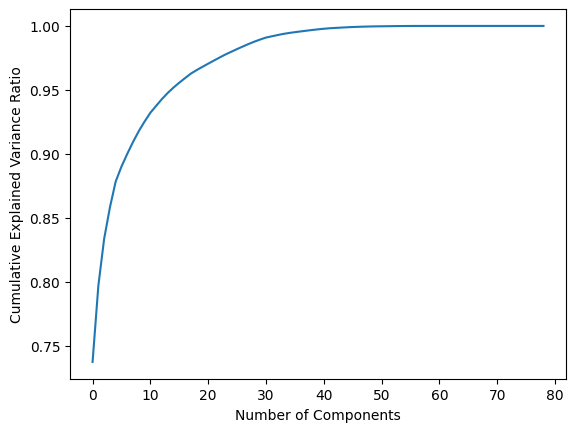

In [132]:
''' Plotting elbow plot and getting n_components '''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.9)

In [133]:
''' Getting ipca value ''' 
_, ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.73731191 0.05954801 0.03664839 0.0245969  0.02026326 0.01167064
 0.00991946 0.00929665]


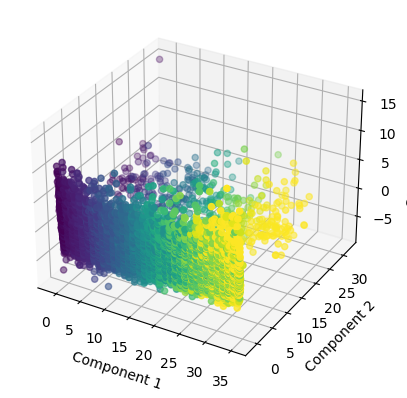

In [134]:
''' Plotting the 3 PCAs '''
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

In [135]:
''' Creating preprocessor and fitting on training data for tree based models '''
tree_preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy(), "tree")
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 8


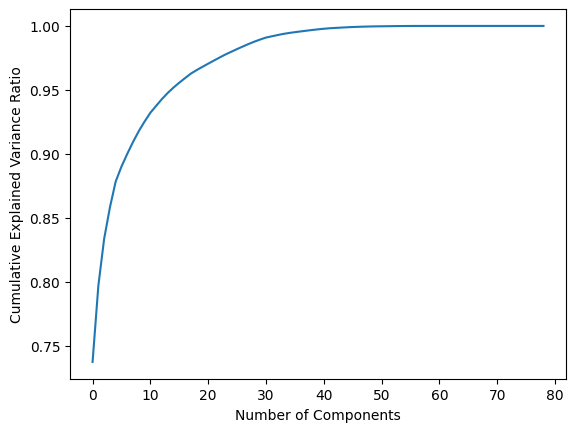

In [136]:
''' Plotting elbow plot and getting n_components '''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.9)

In [137]:
''' Getting ipca value for tree based models '''
_, tree_ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.73731191 0.05954801 0.03664839 0.0245969  0.02026326 0.01167064
 0.00991946 0.00929665]


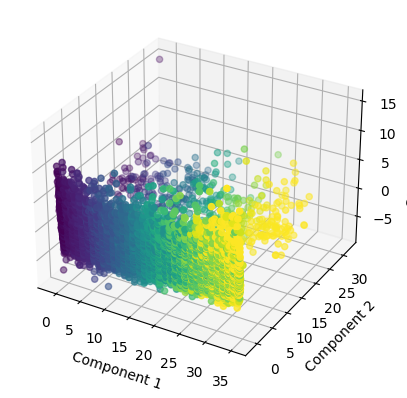

In [138]:
''' Plotting the 3 PCAs for tree '''
helpers.plot_3_pcas(tree_ipca, X_train_transformed, y_train)

#### Interest Rate Prediction Part

For predictint interest rate I will use r2_score and mape for evaluating models.

R2 score measures how well the model fits the data, and MAPE measures the accuracy of the predictions. Both will be useful for evaluating a model that predicts loan interest rates. A high R2 score indicates the model explains the interest rate variability well, and a low MAPE indicates the predictions are close to the actual values.

In [139]:
''' Creating list of models - tree based models and other type of models '''
tree_models = [
                DecisionTreeRegressor(),
                RandomForestRegressor(),
                GradientBoostingRegressor(),
            ]

other_models = [
                LinearRegression(),
                Ridge(),
                Lasso(),
                ElasticNet(), 
                KNeighborsRegressor()
            ]

In [140]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca, X_train, y_train)

The **r2_score** (also known as the coefficient of determination) measures the proportion of variance in the target variable that is explained by the independent variables in the regression model. An r2_score of 1.0 indicates a perfect fit, while a score of 0.0 indicates that the model does not explain any of the variance in the target variable.

The **mean_squared_error** (MSE) measures the average squared difference between the predicted and actual values of the target variable. A lower MSE indicates a better fit of the model.

So, I run the models and we can see top 3 best models for predicting grade:

* **GradientBoostingRegressor** with r2 score of 0.958
* **RandomForestRegressor** with r2 score of 0.957
* **KNeighborsRegressor** with r2 score of 0.952

We can see that the models are behaving relatively well on predicting loan interest rate. Nevertheless, I will perform optuna hyperparameter tuning on each of these top 3 models.

In [141]:
''' Displaying model results '''
print("The best performing models are:") 
models_results = helpers.try_reg_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:] 

The best performing models are:


,model_name,r2_score,rmse
2,GradientBoostingRegressor,0.958532,1.567314
1,RandomForestRegressor,0.957003,1.595942
7,KNeighborsRegressor,0.952396,1.679273
4,Ridge,0.950498,1.712420
3,LinearRegression,0.950498,1.712420
6,ElasticNet,0.948272,1.750505
5,Lasso,0.947485,1.763772
0,DecisionTreeRegressor,0.918957,2.191073


In [142]:
''' Performing optuna tuning on top 3 models '''
results = helpers.optuna_tuning(helpers.objective_reg, models_results.head(3).copy(), X_train, y_train, X_val, y_val, "r2_score")

Tuned GradientBoostingRegressor:


,r2_score,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,learning_rate
0,0.956562,494,12,5,8,log2,0.024644


Tuned RandomForestRegressor:


,r2_score,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,bootstrap
0,0.957993,708,24,3,8,auto,True


Tuned KNeighborsRegressor:


,r2_score,n_neighbors,weights,algorithm,leaf_size,p
0,0.958253,42,distance,brute,52,1


We can see that the highest r2 score scored KNeighborsRegressor but overall the results are quite similar in all of these models

In [143]:
''' Displaying final r2 scores on tuned models '''
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['r2_score'], reverse=True))
dict(sorted({model[1]: result['r2_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

{'KNeighborsRegressor': 0.9582532647176937,
 'RandomForestRegressor': 0.9579928893318514,
 'GradientBoostingRegressor': 0.9565618323589458}

In [144]:
''' Taking final list of models '''
final_top_models = [pipeline[0] for pipeline in list(final_model_results.keys())]

I will now perform cross validation to see how well model behaves on new data and to see maybe they are overfitting. It seems that tree based models RandomForestRegressor and GradientBoostingRegressor might be overfitting a bit.

In [145]:
''' Displaying results of cross validation for 3 models '''
scores, predictions = helpers.perform_cross_validation(final_top_models, X_train, y_train, X_val, y_val, score='r2_score')

------------------------- KNeighborsRegressor -------------------------
TRAIN DATA (cross validated) r2_score is 0.958
VALIDATION DATA - r2_score for the KNeighborsRegressor model is: 0.958

------------------------- RandomForestRegressor -------------------------
TRAIN DATA (cross validated) r2_score is 0.975
VALIDATION DATA - r2_score for the RandomForestRegressor model is: 0.958

------------------------- GradientBoostingRegressor -------------------------
TRAIN DATA (cross validated) r2_score is 0.972
VALIDATION DATA - r2_score for the GradientBoostingRegressor model is: 0.957



A Q-Q plot (Quantile-Quantile plot) is a graphical technique used to compare the distribution of a sample of data to a theoretical distribution. In the context of machine learning, a Q-Q plot can be used to evaluate how well a particular model fits the data.

If the points of a model deviate significantly from the straight line, it may indicate that the residuals are not normally distributed. We can see that these three models follow a similar line, but KNN regressor seems to be the best one.

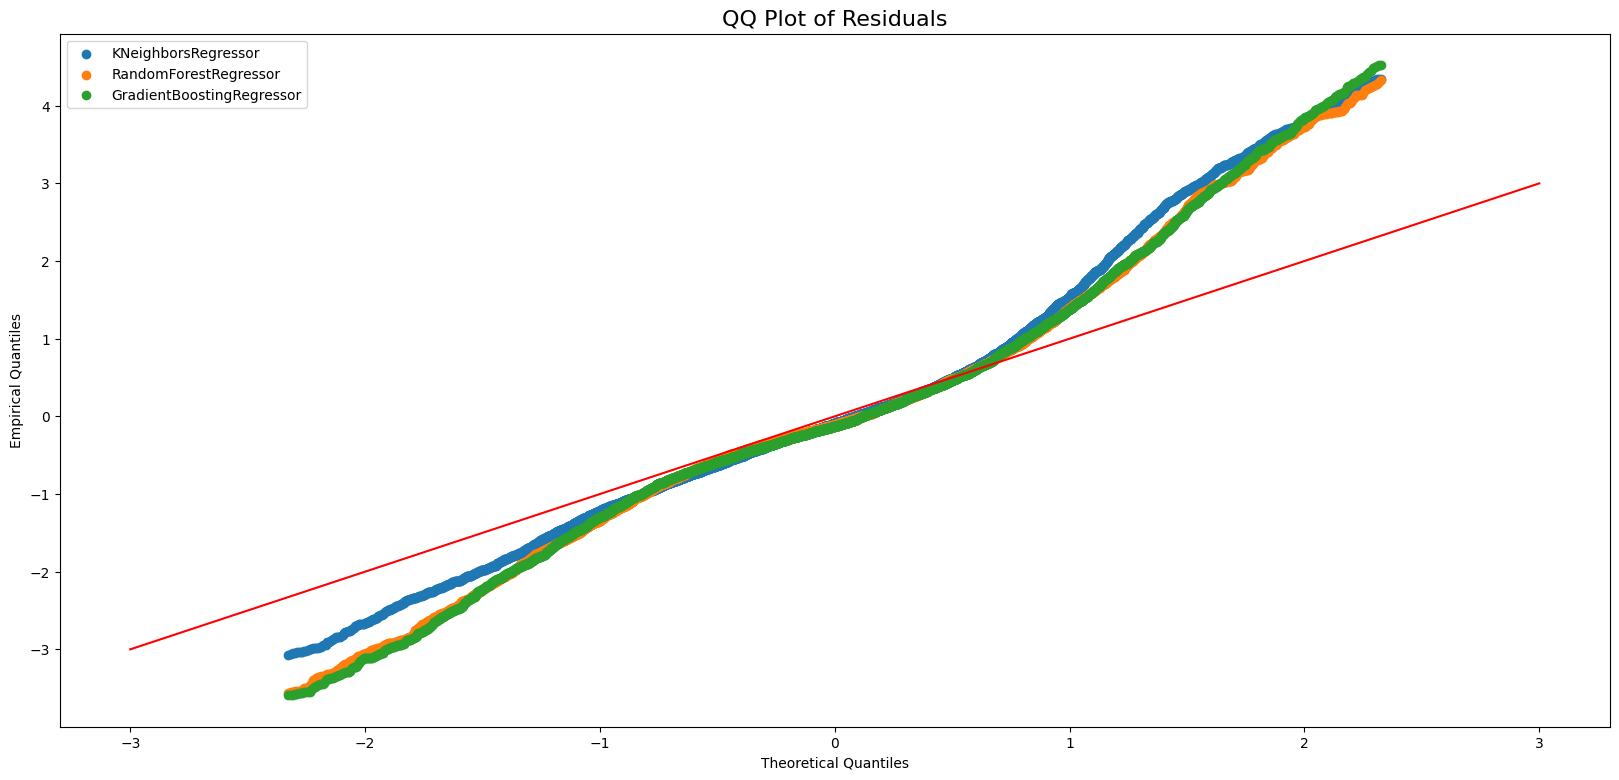

In [146]:
''' Plottig qq plot '''
helpers.plot_qq(predictions, y_val)

Nevertheless, I will check these models by their MAPE values Mean Absolute Percentage Error values. We can see that the RandomForestRegressor has lowest mape value. 

,model,mape
2,GradientBoostingRegressor,0.061052
0,KNeighborsRegressor,0.060882
1,RandomForestRegressor,0.059039


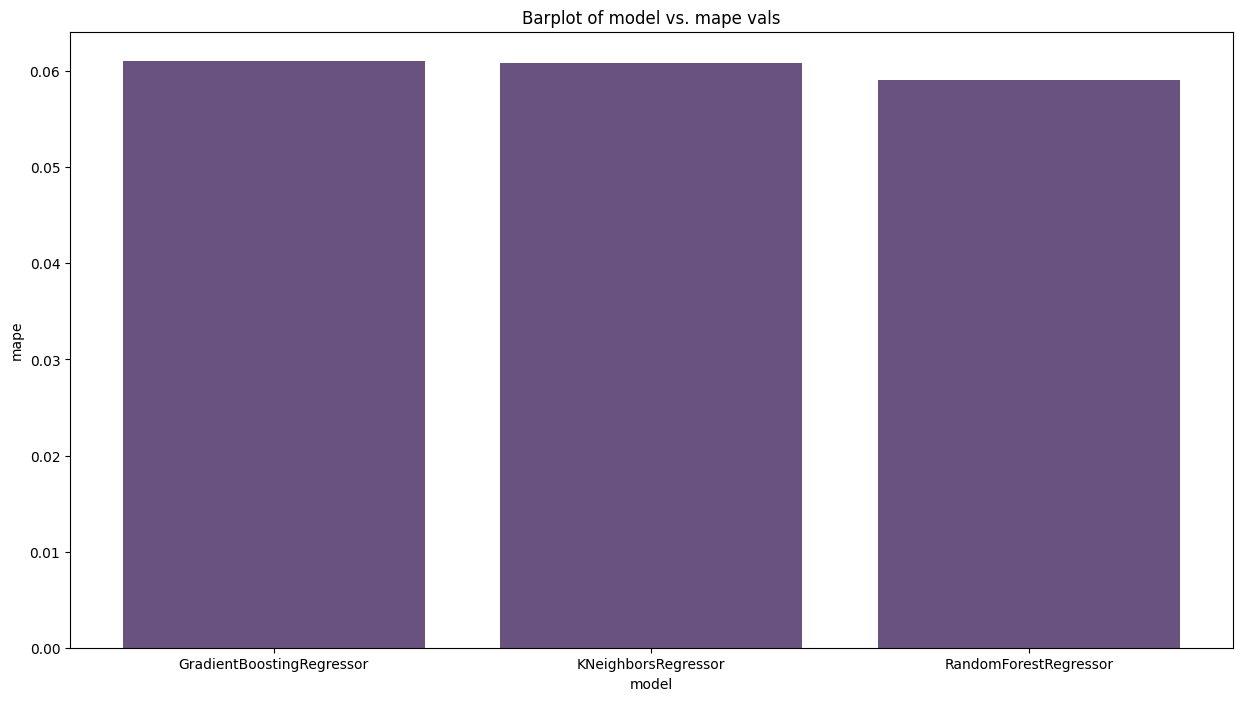

In [147]:
''' Displaying mape values and plotting them '''
helpers.count_and_plot_mape_vals(predictions, y_val)

However, as I noticed before, the tree models were overfitting a bit, therefore, I will choose KNeighbors Regressor over the RandomForestRegressor. 

In [152]:
''' Taking final model '''
KNN_model = list(predictions.keys())[0]
KNN_model.named_steps['model']

KNeighborsRegressor(algorithm='brute', leaf_size=52, n_neighbors=42, p=1,
                    weights='distance')

In [175]:
''' Deploy model into joblib file '''
dump(KNN_model, "step4-int_rate_pred.joblib")

['step4-int_rate_pred.joblib']

## You can now test the whole Loan Prediction application to predict your loan acceptance, grade, subgrade or interest rate! [Lending Club Loan Prediction App](https://eb-loan-prediction-frontend.herokuapp.com)

* You can also access straight to the [backend API](https://eb-loan-prediction-backend.herokuapp.com)
* Github repo for the application: [LoanPredictionApp](https://github.com/baranema/LoanPredictionApp)